## Implementing the original U-Net model

This code implements a U-Net model for semantic segmentation from the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597):

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="your_alt_text" width="500" height="300"/>

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.

The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional

# Implement the double 3X3 convolution blocks
# The original paper did not use padding, but we will use padding to keep the image size the same

class double_convolution(nn.Module):
    """
    This class implements the double convolution block which consists of two 3X3 convolution layers,
    each followed by a ReLU activation function.

    """
    def __init__(self, in_channels, out_channels): # Initialize the class
        super().__init__() # Initialize the parent class

        # First 3X3 convolution layer
        self.first_cnn = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act1 = nn.ReLU()

        # Second 3X3 convolution layer
        self.second_cnn = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act2 = nn.ReLU()

    # Pass the input through the double convolution block
    def forward(self, x):
        x = self.first_cnn(x)
        x = self.act1(x)
        x = self.act2(self.second_cnn(x))
        return x


# Implement the Downsample block that occurs after each double convolution block
class down_sample(nn.Module):
    """
    This class implements the downsample block which consists of a Max Pooling layer with a kernel size of 2.
    The Max Pooling layer halves the image size reducing the spatial resolution of the feature maps
    while retaining the most important features.
    """
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x
    
# Implement the UpSample block that occurs in the decoder part of the network
class up_sample(nn.Module):
    """
    This class implements the upsample block which consists of a convolution transpose layer with a kernel size of 2.
    The convolution transpose layer doubles the image size increasing the spatial resolution of the feature maps
    while retaining the learned features.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer
        self.up_sample = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x 

# Implement the crop and concatenate block that occurs in the decoder part of the network
# This block concatenates the output of the upsample block with the output of the corresponding downsample block
# The output of the crop and concatenate block is then passed through a double convolution block
class crop_and_concatenate(nn.Module):
    """
    This class implements the crop and concatenate block which combines the output of the upsample block
    with the corresponding features from the contracting path through skip connections,
    allowing the network to recover the fine-grained details lost during downsampling
    and produce a high-resolution output segmentation map.
    """ 
    # def forward(self, upsampled, bypass):
    #     # Crop the feature map from the contacting path to match the size of the upsampled feature map
    #     bypass = torchvision.transforms.functional.center_crop(img = bypass, output_size = [upsampled.shape[2], upsampled.shape[3]]) 
    #     # Concatenate the upsampled feature map with the cropped feature map from the contracting path
    #     x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
    #     return x
    # Alternatively crop the upsampled feature map to match the size of the feature map from the contracting path
    def forward(self, upsampled, bypass):
        upsampled = torchvision.transforms.functional.resize(img = upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# m = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
# input = torch.randn(1, 1024, 28, 28)
# m(input).shape 

# m = nn.MaxPool2d(kernel_size = 2, stride = 2)
# xx = torch.randn(1, 1, 143, 143)
# m(xx).shape

## Implement the UNet architecture
class UNet(nn.Module):
    # in_channels: number of channels in the input image
    # out_channels: number of channels in the output image
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Define the contracting path: convolution blocks followed by downsample blocks
        self.down_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, 64), (64, 128), (128, 256), (256, 512)]) # List of downsample blocks
        
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck layer
        self.bottleneck = double_convolution(in_channels = 512, out_channels = 1024)

        # Define the expanding path: upsample blocks followed by convolution blocks
        self.up_samples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of upsample blocks
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of convolution blocks
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv2d(in_channels = 64, out_channels = out_channels, kernel_size = 1)

    # Pass the input through the UNet architecture
    def forward(self, x):
        # Pass the input through the contacting path
        skip_connections = [] # List to store the outputs of the downsample blocks
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)
        
        # Pass the output of the contacting path through the bottleneck layer
        x = self.bottleneck(x)

        # Pass the output of the bottleneck layer through the expanding path
        skip_connections = skip_connections[::-1] # Reverse the list of skip connections
        for up_sample, concat, up_conv in zip(self.up_samples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, skip_connections.pop(0)) # Remove the first element from the list of skip connections
            x = up_conv(x)
        
        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x


### Sanity check for the model


In [ ]:
# !pip install torchsummary
import torchsummary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels = 3, out_channels = 1).to(device)
dummy_input = torch.randn((1, 3, 32, 32)).to(device)
mask = model(dummy_input)
mask.shape

In [ ]:
# See how data flows through the network
torchsummary.summary(model, input_size = (3, 32, 32))

## Going deeper: Some more interesting UNets


This section implemets a U-Net model that incorporates some of the recent advances in deep learning, that is:



- [Residual networks for UNets](https://arxiv.org/abs/1802.06955): The key idea behind ResNets is the use of residual connections, which allow for the direct propagation of information through the network without being modified by the layers in between. The residual connection is achieved by adding the input of a layer to its output, so that the output of the layer becomes: `y = f(x) + x`. **The shortcut connection skips one or more layers, with the change in dimensions, if any, compensated with a 1x1 convolutional layer.**

::: {style="text-align:center"}
<img src="rnns.PNG" width="50%" height="50%"/>
:::

-   [Group normalization](https://arxiv.org/abs/1803.08494): works by normalizing the activations of a layer across groups of channels instead of the entire batch. See more explanations and comparisons between different normalizations in [this blog post](https://gaoxiangluo.github.io/2021/08/01/Group-Norm-Batch-Norm-Instance-Norm-which-is-better/).

::: {style="text-align:center"}
<img src="normalizations.PNG" width="50%" height="50%"/>
:::

-   [Swish activation function](https://arxiv.org/abs/1710.05941): is a self-gated activation function that is defined as `f(x) = x * sigmoid(x)`. It has been shown to outperform ReLU and other activation functions on deeper models across a number of challenging datasets.

::: {style="text-align:center"}
<img src="swish.PNG" width="40%" height="40%"/>
:::

-   [Attention gated Unets](https://arxiv.org/abs/1804.03999): is a modification of the U-Net architecture that uses attention gates to selectively focus on the most relevant parts of the input image. The attention gates are implemented as a 1x1 convolutional layer that learns a weight for each channel in the input. The output of the attention gate is then multiplied with the input to the layer, so that the output of the layer becomes: `y = f(x) * sigmoid(x)`. The attention gates are applied to the output of the contracting path and the input of the expanding path.

::: {style="text-align:center"}
<img src="attention_unet.png" alt="your_alt_text" width="50%" height="50%"/>
:::


In [1]:
import torch
import torch.nn as nn
import torchvision

# Define a Residual block
class residual_block(nn.Module):
    """
    This class implements a residual block which consists of two convolution layers with group normalization
    """
    def __init__(self, in_channels, out_channels, n_groups = 8):
        super().__init__()
        # First convolution layer
        self.first_conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.first_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act1 = nn.SiLU() # Swish activation function

        # Second convolution layer
        self.second_conv = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.second_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act2 = nn.SiLU() # Swish activation function

        # If the number of input channels is not equal to the number of output channels,
        # then use a 1X1 convolution layer to compensate for the difference in dimensions
        # This allows the input to have the same dimensions as the output of the residual block
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1)
        else:
            # Pass the input as is
            self.shortcut = nn.Identity()

    # Pass the input through the residual block
    def forward(self, x):
        # Store the input
        input = x

        # Pass input through the first convolution layer
        x = self.act1(self.second_norm(self.first_conv(x)))

        # Pass the output of the first convolution layer through the second convolution layer
        x = self.act2(self.second_norm(self.second_conv(x)))

        # Add the input to the output of the second convolution layer
        # This is the skip connection
        x = x + self.shortcut(input)
        return x

# Implement the DownSample block that occurs after each residual block
class down_sample(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x

# Implement the UpSample block that occurs in the decoder path/expanding path
class up_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer to upsample the input
        self.up_sample = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x

# Implement the crop and concatenate layer
class crop_and_concatenate(nn.Module):
    def forward(self, upsampled, bypass):
        # Crop the upsampled feature map to match the dimensions of the bypass feature map
        upsampled = torchvision.transforms.functional.resize(upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# Implement an attention block
class attention_block(nn.Module):
    def __init__(self, skip_channels, gate_channels, inter_channels = None, n_groups = 8):
        super().__init__()

        if inter_channels is None:
            inter_channels = skip_channels // 2

        # Implement W_g i.e the convolution layer that operates on the gate signal
        # Upsample gate signal to be the same size as the skip connection
        self.W_g = up_sample(in_channels = gate_channels, out_channels = skip_channels)
        #self.W_g_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)
        #self.W_g_act = nn.SiLU() # Swish activation function

        # Implement W_x i.e the convolution layer that operates on the skip connection
        self.W_x = nn.Conv2d(in_channels = skip_channels, out_channels = inter_channels, kernel_size = 1)
        #self.W_x_norm = nn.GroupNorm(num_groups = n_groups, num_channels = inter_channels)
        #self.W_x_act = nn.SiLU() # Swish activation function

        # Implement phi i.e the convolution layer that operates on the output of W_x + W_g
        self.phi = nn.Conv2d(in_channels = inter_channels, out_channels = 1, kernel_size = 1)
        #self.phi_norm = nn.GroupNorm(num_groups = n_groups, num_channels = 1)
        #self.phi_act = nn.SiLU() # Swish activation function

        # Implement the sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        # Implement the Swish activation function
        self.act = nn.SiLU()

        # Implement final group normalization layer
        self.final_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)

    # Pass the input through the attention block
    def forward(self, skip_connection, gate_signal):
        # Upsample the gate signal to match the channels of the skip connection
        gate_signal = self.W_g(gate_signal)
        # Ensure that the sizes of the skip connection and the gate signal match before addition
        if gate_signal.shape[2:] != skip_connection.shape[2:]:
            gate_signal = torchvision.transforms.functional.resize(gate_signal, size = skip_connection.shape[2:], antialias=True)
        # Project to the intermediate channels
        gate_signal = self.W_x(gate_signal)

        # Project the skip connection to the intermediate channels
        skip_signal = self.W_x(skip_connection)

        # Add the skip connection and the gate signal
        add_xg = gate_signal + skip_signal

        # Pass the output of the addition through the activation function
        add_xg = self.act(add_xg)

        # Pass the output of attention through a 1x1 convolution layer to obtain the attention map
        attention_map = self.sigmoid(self.phi(add_xg))

        # Multiply the skip connection with the attention map
        # Perform element-wise multiplication
        skip_connection = torch.mul(skip_connection, attention_map)

        skip_connection = nn.Conv2d(in_channels = skip_connection.shape[1], out_channels = skip_connection.shape[1], kernel_size = 1)(skip_connection)
        skip_connection = self.act(self.final_norm(skip_connection))

        return skip_connection


## Implement a residual attention U-Net
class ResidualAttentionUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [64, 128, 256, 512, 1024]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])


        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])


        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv2d(in_channels = n_channels[0] , out_channels = out_channels, kernel_size = 1)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []
        # # Store the gate signals
        # gate_signals = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            #gate_signals.append(x)
            x = down_sample(x)
        
        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        skip_connections.append(x)

        # Attention on the residual connections
        #skip_connections = skip_connections[::-1]
        n = len(skip_connections)
        indices = [(n - 1 - i, n - 2 - i) for i in range(n - 1)]
        attentions = []
        for i, g_x in enumerate(indices):
            g_gate = g_x[0]
            x_residual = g_x[1]
            attn = self.attention_blocks[i](skip_connections[x_residual], skip_connections[g_gate])
            attentions.append(attn)

        #attentions = attentions[::-1]
    
        # Pass the output of the attention blocks through the expanding path
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, attentions.pop(0))
            x = up_conv(x)

        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x

### Sanity check


In [2]:
## Sanity check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualAttentionUnet(in_channels = 3, out_channels = 1).to(device)
x = torch.randn((1, 3, 32, 32)).to(device)
mask = model(x)
mask.shape

torch.Size([1, 1, 32, 32])

In [ ]:
# See how data flows through the network
torchsummary.summary(model, input_size = (3, 32, 32))

## Prepare the data

In this section, we prepare the data for training and evaluation to match:

- train images + segmentation masks
- validation images + segmentation masks
- test images + segmentation masks

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
import os

# Set the random seed for reproducibility
random.seed(2056)

# Read all files ending with _img.nii
img_path = Path("data/data")
img_files = list(img_path.glob("*_img.nii")) # Image and mask are in the same folder
num_images = len(img_files) 

# Create train, validation and test splits
train_split = int(0.7 * num_images)
val_split = int(0.15 * num_images)
test_split = int(num_images - (train_split + val_split))

# Shuffle the image files
random.shuffle(img_files)

# Split the dataset
train_images = img_files[:train_split]
val_images = img_files[train_split:(train_split + val_split)]
test_images = img_files[(train_split + val_split): ]

# Create train, validation and test directories
train_image_dir = Path(img_path / "train_images")
train_mask_dir = Path(img_path / "train_masks")
val_image_dir = Path(img_path / "val_images")
val_mask_dir = Path(img_path / "val_masks")
test_image_dir = Path(img_path / "test_images")
test_mask_dir = Path(img_path / "test_masks")

# Create the directories if they don't exist
if not os.path.exists(train_image_dir) and not os.path.exists(train_mask_dir) and not os.path.exists(val_image_dir) and not os.path.exists(val_mask_dir) and not os.path.exists(test_image_dir) and not os.path.exists(test_mask_dir):
    for directory in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir]:
        directory.mkdir(exist_ok = True, parents = True)

    # Copy the images and their corresponding segmentation masks to their respective directories
    for directory, images in zip([train_image_dir, val_image_dir, test_image_dir], [train_images, val_images, test_images]):
        for image in images:
            # Copy image
            copyfile(image, directory / image.name)

            # Get corresponding segmentation mask
            mask = image.name.replace("_img.nii", "_mask.nii")

            # Copy segmentation mask
            copyfile(image.parent / mask, image.parent / directory.name.replace("images", "masks") / mask)


# # Sanity check
# train_images_s = list(train_image_dir.glob("*"))
# train_images_s = [image.name.removesuffix("_img.nii") for image in train_images_s]
# train_masks_s = list(train_mask_dir.glob("*"))
# train_masks_s = [mask.name.removesuffix("_mask.nii") for mask in train_masks_s]
# train_images_s == train_masks_s








In [2]:
tt = os.listdir(train_image_dir)
tm = os.listdir(train_mask_dir)
tt[10], tm[10]

('002014_img.nii', '002014_mask.nii')

In [65]:
# !pip install nibabel
# !pip install matplotlib
# List of train images
train_images = list(train_image_dir.glob("*"))
train_masks = list(train_mask_dir.glob("*"))
train_images[0], train_masks[0]

import nibabel as nib
import matplotlib.pyplot as plt

# Load an image and its corresponding mask
image = nib.load(train_images[329])
mask = nib.load(train_masks[329])

# Get the image and mask data
image_data = image.get_fdata()
mask_data = mask.get_fdata()

image_data.shape, mask_data.shape

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-15 22:58:19,489 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


((400, 400, 32), (400, 400, 32))

In [5]:
# Read all input images and find shape
img_files = list(img_path.glob("*_img.nii"))
msk_files = list(img_path.glob("*_mask.nii"))
# Empty array to store the shapes of the images
img_shapes = np.empty((len(img_files), 3))
for img in img_files:
    image = nib.load(img)
    image_data = image.get_fdata()
    #print(image_data.shape)
    img_shapes[img_files.index(img)] = image_data.shape

# Find the maximum shape\
np.max(img_shapes, axis = 0)

array([640., 640.,  95.])

In [31]:
# Find index of the image with the maximum shape
np.argmax(img_shapes, axis = 0)

array([329, 329, 455], dtype=int64)

In [32]:
img_files[329]

WindowsPath('data/data/004034_img.nii')

In [10]:
type(image_data)

numpy.memmap

(199, 199, 95) (199, 199, 95)


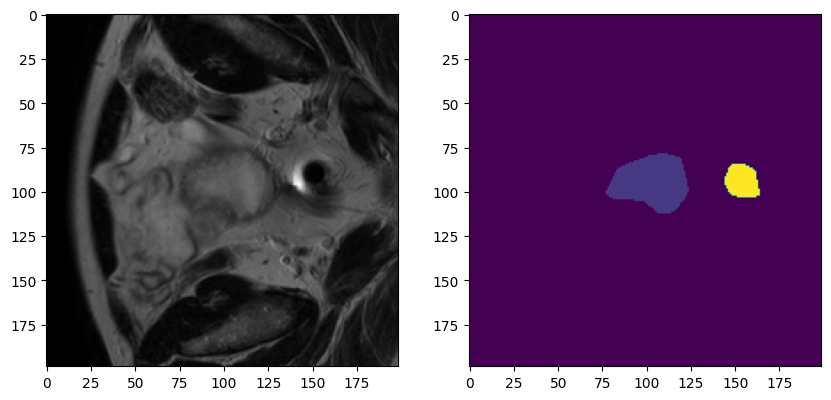

In [80]:
image = nib.load(img_files[455]).get_fdata()
mask = nib.load(msk_files[455]).get_fdata()
print(image.shape, mask.shape)

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(image[:, :, 30], cmap = "gray")
ax[1].imshow(mask[:, :, 30])

torch.Size([256, 256, 40]) torch.Size([256, 256, 40])


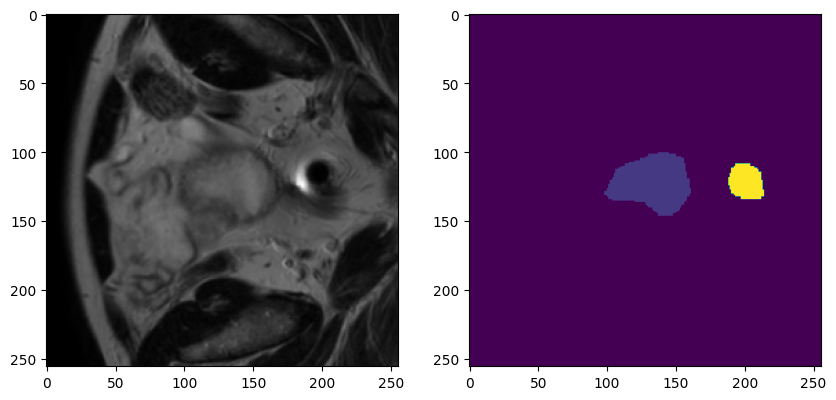

In [93]:
# Dummy data in a dictionary train_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(train_images, train_masks)]
dum_data = [{"image": image, "mask": mask} for image, mask in zip([img_files[455]], [msk_files[455]])]
dum_ds = Dataset(dum_data, transform = val_transforms)
dum_dl = DataLoader(dum_ds, batch_size = 1, shuffle = False)
check_data = first(dum_dl)
image = check_data["image"][0][0]
mask = check_data["mask"][0][0]

print(image.shape, mask.shape)

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(image[:, :, 6], cmap = "gray")
ax[1].imshow(mask[:, :, 6])



In [56]:
len(dum_dl)

1

In [55]:
dt = val_transforms(dum_data)
dt['image']

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-06 21:45:13,934 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


TypeError: list indices must be integers or slices, not str

In [11]:
# Test nn.Conv3d
conv = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
# 320, 320, 25
inp = torch.randn(1, 1, 25, 320, 320)
out = conv(inp)
# Pass through a downsampling layer
out = nn.MaxPool3d(kernel_size=2, stride=2)(out)

# Pass output through transpose convolution
out = nn.ConvTranspose3d(in_channels=1, out_channels=1, kernel_size=2, stride=2)(out)

# Resize the output to match the input
out = nn.Upsample(size=inp.shape[2:], mode="trilinear", align_corners=True)(out)
out.shape

torch.Size([1, 1, 25, 320, 320])

## Create a 3D U-Net model

In [2]:
import torch
import torch.nn as nn
import torchvision


# Define a Residual block
class residual_block(nn.Module):
    """
    This class implements a residual block which consists of two convolution layers with group normalization
    """
    def __init__(self, in_channels, out_channels, n_groups = 8):
        super().__init__()
        # First convolution layer
        self.first_conv = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias=False)
        self.first_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act1 = nn.SiLU() # Swish activation function

        # Second convolution layer
        self.second_conv = nn.Conv3d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias = False)
        self.second_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act2 = nn.SiLU() # Swish activation function

        # Add dropout to the residual block
        self.dropout = nn.Dropout3d(p = 0.2)

        # If the number of input channels is not equal to the number of output channels,
        # then use a 1X1 convolution layer to compensate for the difference in dimensions
        # This allows the input to have the same dimensions as the output of the residual block
        if in_channels != out_channels:
            self.shortcut = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)
        else:
            # Pass the input as is
            self.shortcut = nn.Identity()

    # Pass the input through the residual block
    def forward(self, x):
        # Store the input
        input = x

        # Pass input through the first convolution layer
        x = self.act1(self.first_norm(self.first_conv(x)))

        # Pass the output of the first convolution layer through the second convolution layer
        x = self.act2(self.second_norm(self.second_conv(x)))

        # Add dropout
        x = self.dropout(x)


        # Add the input to the output of the second convolution layer
        # This is the skip connection
        x = x + self.shortcut(input)
        return x

# Implement the DownSample block that occurs after each residual block
class down_sample(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool3d(kernel_size = 2, stride = 2)

    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x

# Implement the UpSample block that occurs in the decoder path/expanding path
class up_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer to upsample the input
        self.up_sample = nn.ConvTranspose3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2, bias = False)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x

# Implement the crop and concatenate layer
class crop_and_concatenate(nn.Module):
    def forward(self, upsampled, bypass):
        # Crop the upsampled feature map to match the dimensions of the bypass feature map
        if upsampled.shape[2:] != bypass.shape[2:]:
            upsampled = nn.Upsample(size = bypass.shape[2:], mode="trilinear", align_corners=True)(upsampled)

        #upsampled = torchvision.transforms.functional.resize(upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# Implement an attention block
class attention_block(nn.Module):
    def __init__(self, skip_channels, gate_channels, inter_channels = None, n_groups = 8):
        super().__init__()

        if inter_channels is None:
            inter_channels = skip_channels // 2

        # Implement W_g i.e the convolution layer that operates on the gate signal
        # Upsample gate signal to be the same size as the skip connection
        self.W_g = up_sample(in_channels = gate_channels, out_channels = skip_channels)
        self.W_g_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)
        self.W_g_act = nn.SiLU() # Swish activation function

        # Implement W_x i.e the convolution layer that operates on the skip connection
        self.W_x = nn.Conv3d(in_channels = skip_channels, out_channels = inter_channels, kernel_size = 1, padding = 0, bias = False)
        self.W_x_norm = nn.GroupNorm(num_groups = n_groups, num_channels = inter_channels)
        self.W_x_act = nn.SiLU() # Swish activation function

        # Implement phi i.e the convolution layer that operates on the output of W_x + W_g
        self.phi = nn.Conv3d(in_channels = inter_channels, out_channels = 1, kernel_size = 1, padding = 0, bias = False)
        #self.phi_norm = nn.GroupNorm(num_groups = n_groups, num_channels = 1)
        #self.phi_act = nn.SiLU() # Swish activation function

        # Implement the sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        # Implement the Swish activation function
        self.act = nn.SiLU()

        # Implement final group normalization layer
        self.final_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)

    # Pass the input through the attention block
    def forward(self, skip_connection, gate_signal):
        # Upsample the gate signal to match the channels of the skip connection
        gate_signal = self.W_g(gate_signal)
        # Ensure that the sizes of the skip connection and the gate signal match before addition
        if gate_signal.shape[2:] != skip_connection.shape[2:]:
            gate_signal = nn.Upsample(size = skip_connection.shape[2:], mode="trilinear", align_corners=True)(gate_signal)
            #gate_signal = torchvision.transforms.functional.resize(gate_signal, size = skip_connection.shape[2:], antialias=True)
        # Project to the intermediate channels
        gate_signal = self.W_x(gate_signal)

        # Project the skip connection to the intermediate channels
        skip_signal = self.W_x(skip_connection)

        # Add the skip connection and the gate signal
        add_xg = gate_signal + skip_signal

        # Pass the output of the addition through the activation function
        add_xg = self.act(add_xg)

        # Pass the output of attention through a 1x1 convolution layer to obtain the attention map
        attention_map = self.sigmoid(self.phi(add_xg))

        # Multiply the skip connection with the attention map
        # Perform element-wise multiplication
        skip_connection = torch.mul(skip_connection, attention_map)

        skip_connection = nn.Conv3d(in_channels = skip_connection.shape[1], out_channels = skip_connection.shape[1], kernel_size = 1, bias=False).to(device)(skip_connection)
        skip_connection = self.act(self.final_norm(skip_connection))

        return skip_connection


## Implement a 3D residual attention U-Net
class ResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [16, 32, 64, 128, 256]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])


        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])


        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv3d(in_channels = n_channels[0] , out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []
        # # Store the gate signals
        # gate_signals = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            #gate_signals.append(x)
            x = down_sample(x)
        
        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        skip_connections.append(x)

        # Attention on the residual connections
        n = len(skip_connections)
        indices = [(n - 1 - i, n - 2 - i) for i in range(n - 1)]
        attentions = []
        for i, g_x in enumerate(indices):
            g_gate = g_x[0]
            x_residual = g_x[1]
            attn = self.attention_blocks[i](skip_connections[x_residual], skip_connections[g_gate])
            attentions.append(attn)

        #attentions = attentions[::-1]
    
        # Pass the output of the attention blocks through the expanding path
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, attentions.pop(0))
            x = up_conv(x)

        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x

In [3]:
## Correct gate attention implementation
## Implement a 3D residual attention U-Net
class ResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [16, 32, 64, 128, 256]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])


        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])


        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv3d(in_channels = n_channels[0] , out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []
       

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)
        
        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        

        # Initialize the attention block counter and the skip connection counter
        att_block_count = 0
        skip_connections_count = len(skip_connections)
    
        # Pass the output of the attention blocks through the expanding path
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            gated_attn = self.attention_blocks[att_block_count](skip_connections[skip_connections_count - 1], x)
            att_block_count += 1
            skip_connections_count -= 1
            x = up_sample(x)
            x = concat(x, gated_attn)
            x = up_conv(x)

        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x
    
# Test if 3d U-Net works
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualAttention3DUnet(in_channels = 1, out_channels = 9).to(device)
x = torch.randn(1, 1, 40, 256, 256).to(device)
mask = model(x)
mask.shape
    


torch.Size([1, 9, 40, 256, 256])

In [18]:
a = [1, 2, 3, 4]
len(a), a[3]

(4, 4)

In [ ]:
# Test if 3d U-Net works
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualAttention3DUnet(in_channels = 2, out_channels = 1).to(device)
x = torch.randn(1, 1, 40, 256, 256).to(device)
mask = model(x)
mask.shape

## Multi-task learning 3D unet

In this section, we create a MTL Unet which takes a 3D image as input, uses the first decoder for **image segmentation**: main task, and the second decoder for image reconstruction.

> Perhaps we can do a 3rd binary task for binary mask classification? Ask Ela..

In [4]:
## Implement a MTL 3D residual attention U-Net
class MTLResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [16, 32, 64, 128, 256]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(len(n_channels) - 1))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])

        ## ------ Decoder block for the segmentation task ------ ##
        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        

        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv3d(in_channels = n_channels[0], out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)

        ## --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ##
        ###** Add second decoder path for image reconstruction **###
        self.attention_blocks_recon = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                                [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])

        self.upsamples_recon = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        self.concat_recon = nn.ModuleList(crop_and_concatenate() for _ in range(4))
        self.up_conv_recon = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                        [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        # Final 1x1 convolution layer to produce the reconstructed image
        self.final_conv_recon = nn.Conv3d(in_channels = n_channels[0], out_channels = in_channels, kernel_size = 1, padding = 0, bias = False)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)

        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        

        # Define segmentation and reconstruction variables
        x_seg = x
        x_recon = x

       


       # --- Pass the ouput of encoder

        # --- Pass the output of the attention blocks through the expanding path of the segmentation path --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            gated_attn = self.attention_blocks[attn_block_count](skip_connections[skip_connections_count - 1], x_seg)
            attn_block_count += 1
            skip_connections_count -= 1
            x_seg = up_sample(x_seg)
            x_seg = concat(x_seg, gated_attn)
            x_seg = up_conv(x_seg)

        # Pass the output of the expanding path through the final convolution layer
        x_seg = self.final_conv(x_seg) # Output segmentation map

        # Pass the output of the attention blocks through the expanding path of the reconstruction path
        attn_block_count = 0
        skip_connections_count = len(skip_connections)
        for up_sample, concat, up_conv in zip(self.upsamples_recon, self.concat_recon, self.up_conv_recon):
            gated_attn = self.attention_blocks_recon[attn_block_count](skip_connections[skip_connections_count - 1], x_recon)
            attn_block_count += 1
            skip_connections_count -= 1
            x_recon = up_sample(x_recon)
            x_recon = concat(x_recon, gated_attn)
            x_recon = up_conv(x_recon)

        # Pass the output of the expanding path through the final convolution layer
        x_recon = self.final_conv_recon(x_recon) # Output reconstructed image

        return x_seg, x_recon
    
# Test whether the MTL model works
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MTLResidualAttention3DUnet(in_channels = 1, out_channels = 9).to(device)
x = torch.randn(2, 1, 40, 256, 256).to(device)
mask, recon = model(x)
mask.shape, recon.shape




NameError: name 'residual_block' is not defined

In [ ]:
# Find loss between reconstructed image and original image
recon_loss = nn.MSELoss(reduction='none')
recon_loss(recon, x)

## Create train and test datasets

Pytorch Dataset class is used to create train and test datasets while the DataLoader class is used to create data loaders for train and test datasets.

In [61]:
# Create a custom Dataset class
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Subclass the Dataset class
class MedicalSegmentationDataset(Dataset):
    # Initialize custom dataset
    def __init__(self, image_paths, mask_paths, transforms = None):
    # Create class atrributes
        self.images = list(image_paths.glob('*'))
        self.masks = list(mask_paths.glob('*'))
        self.transforms = transforms

    # Return the length of the dataset
    def __len__(self):
        return len(self.images)
    
    # Function to read the image and mask at a given index
    
    
    # Override the getitem method to return the image and mask at a given index
    def __getitem__(self, index):
        # Read the image and mask at the given index
        image = nib.load(self.images[index]).get_fdata()
        mask = nib.load(self.masks[index]).get_fdata()

        # Add a channel dimension to the image and mask
        image = np.expand_dims(image, axis = 0)
        mask = np.expand_dims(mask, axis = 0)

        # Apply transformations to the image and mask
        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)

        # Convert to tensor
        image = torch.from_numpy(image).float().permute(0, 3, 1, 2)
        mask = torch.from_numpy(mask).long().permute(0, 3, 1, 2)
        
        return image, mask
    

    
# Create transforms to convert the image and mask to tensors
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])

# Create a dataset object
train_dataset = MedicalSegmentationDataset(image_paths = train_image_dir, mask_paths = train_mask_dir)
validation_dataset = MedicalSegmentationDataset(image_paths = val_image_dir, mask_paths = val_mask_dir)
test_dataset = MedicalSegmentationDataset(image_paths = test_image_dir, mask_paths = test_mask_dir)


In [62]:

# Create data loaders to load the data in batches
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
validation_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)


In [ ]:

# Make sure the data loader works
sch_images, sch_masks = next(iter(train_loader))
sch_images.shape, sch_masks.shape




In [ ]:
# Get the image and mask at index 0
image, mask = train_dataset[30]
# Visualize the image and mask
# plt.imshow(image[0, 24, :, :])
# plt.show()
# plt.imshow(mask[0, 24, :, :])
# plt.show()

# Create function to visualize the image and mask side by side
def visualize(image, mask, index):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].imshow(image[0, index, :, :])
    ax[1].imshow(mask[0, index, :, :])
    plt.show()

# Visualize the image and mask at index 24
print(image.shape)
visualize(image, mask, 24)


In [79]:
image.shape

torch.Size([1, 25, 320, 320])

In [59]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(412, 88, 89)

## Data augementation with Monai

In [4]:
#!pip install monai
from monai.utils import first, set_determinism 
from monai.transforms import (
    EnsureChannelFirstd, # Adjust or add the channel dimension of input data to ensure channel_first shape.
    #AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    ScaleIntensityd,
    Spacingd,
    SpatialPadd,
    ToTensord,
    RandAffined, Resized, RandSpatialCropd,
)

# Set deterministic training for reproducibility
set_determinism(seed = 2056)

# Put the train images and masks in a dictionary
train_images = sorted(train_image_dir.glob("*"))
train_masks = sorted(train_mask_dir.glob("*"))
train_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(train_images, train_masks)]

# Put the validation images and masks in a dictionary
val_images = sorted(val_image_dir.glob("*"))
val_masks = sorted(val_mask_dir.glob("*"))
val_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(val_images, val_masks)]

# Put the test images and masks in a dictionary
test_images = sorted(test_image_dir.glob("*"))
test_masks = sorted(test_mask_dir.glob("*"))
test_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(test_images, test_masks)]

# Create transforms for training
train_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"), # Interpolation mode for image and mask
        ),
        RandAffined(
            keys = ["image", "mask"],
            mode = ("bilinear", "nearest"),
            prob = 1.0,
            spatial_size = (256, 256, 40), # Output size of the image [height, width, depth]
            #rotate_range = (np.pi / 36, np.pi / 36, np.pi / 36), # Rotation range
            scale_range = (0.1, 0.1, 0.1), # Scaling range
            padding_mode="zeros", # This means that the image will be padded with zeros
        )

        
    ]
)

# Create transforms for validation
val_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"),
        ),
        # since we are not doing data augmentation during validation,
        #we simply center crop the image and mask to the specified size of [256, 256, 40]
        CenterSpatialCropd(keys = ["image", "mask"], roi_size = (256, 256, 40)), 
        SpatialPadd(keys = ["image", "mask"], spatial_size= (256, 256, 40)) # Some images are smaller than 256x256x40, so we pad them to this size


        

    ]
)

### Check transforms in DataLoader

Let's verify the transforms using a `monai.data.DataLoader`.

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-19 03:41:07,929 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Image shape: torch.Size([1, 256, 256, 40]), mask shape torch.Size([1, 256, 256, 40])


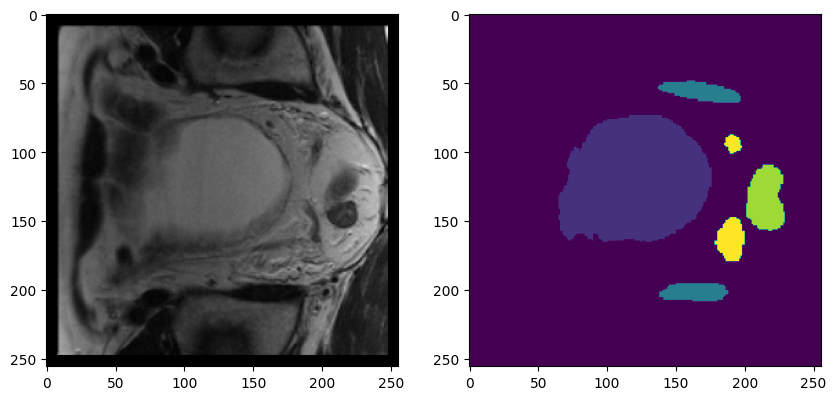

In [5]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
import matplotlib.pyplot as plt
def visualize(image, mask, index):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].imshow(image[0, :, :, index], cmap="gray")
    ax[1].imshow(mask[0, :, :, index])
    plt.show()
check_ds = Dataset(data = val_files, transform = val_transforms)
check_dl = DataLoader(check_ds, batch_size = 8, num_workers = 0)
check_data = first(check_dl)
image, mask = (check_data["image"][0], check_data["mask"][0])
print(f"Image shape: {image.shape}, mask shape {mask.shape}")
visualize(image, mask, 35)


In [6]:
# Test if 3d U-Net works
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualAttention3DUnet(in_channels = 1, out_channels = 9).to(device)
x = check_data["image"].permute(0, 1, 4, 2, 3).to(device) # Permute the dimensions to [batch, channel, depth, height, width]
mask = model(x).permute(0, 1, 3, 4, 2)
mask.shape

torch.Size([8, 9, 256, 256, 40])

In [12]:
check_data["image"].shape

torch.Size([8, 1, 256, 256, 40])

In [14]:
check_data["mask"].unique()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [16]:
x.shape

torch.Size([8, 1, 40, 256, 256])

In [18]:
torch.argmax(mask, dim = 1).shape

torch.Size([8, 256, 256, 40])

In [16]:
# Verify inference works
from monai.transforms import AsDiscrete
post_pred_transform = Compose([AsDiscrete(argmax = True, to_onehot = 9)])
from monai.inferers import sliding_window_inference
model.eval()
with torch.inference_mode():
    #pred = model(x)
    pred_outputs = [post_pred_transform(i) for i in decollate_batch(mask)]

In [20]:
pred_outputs[3].shape

torch.Size([9, 256, 256, 40])

In [36]:
len(pred_outputs)

2

In [72]:
pred.shape

torch.Size([1, 1, 40, 256, 256])

In [71]:
for i in decollate_batch(pred.permute(0, 1, 3, 4, 2)):
    print(i.shape)

torch.Size([1, 256, 256, 40])


In [67]:
check_dl = DataLoader(check_ds, batch_size = 4, num_workers = 0)
len(check_dl)

22

### Define CacheDataset and DataLoader for training and validation

CacheDataset is used to cache the data in memory for faster training and validation. To achieve best performance, cache_rate is set to 1.0 to cache all the data in memory but can be set to a lower value to cache a subset of the data in memory.

In [6]:
# !pip install tqdm
torch.cuda.empty_cache()
from tqdm import tqdm
BATCH_SIZE = 2
#train_ds = CacheDataset(data = train_files, transform = train_transforms, cache_rate = 1.0, num_workers = 4)
train_ds = Dataset(data = train_files, transform = train_transforms)
train_dl = DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

#val_ds = CacheDataset(data = val_files, transform = val_transforms, cache_rate = 1.0, num_workers = 4)
val_ds = Dataset(data = val_files, transform = val_transforms)
val_dl = DataLoader(dataset = val_ds, batch_size = BATCH_SIZE, num_workers = 4, shuffle = False)


### Create model, optimizer and loss function

In [40]:
# # # Clear the cache
# torch.cuda.empty_cache()

In [ ]:
# Find accuracy of reconstruction
def compute_accuracy(pred, label):
    pred = pred.argmax(dim = 1)
    correct = (pred == label).sum().item()
    total = len(label)
    return correct / total



In [14]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Input image has eight anatomical structures of planning interest
model = MTLResidualAttention3DUnet(in_channels = 1, out_channels = 9).to(device) # 8 structures + background
loss_function = DiceLoss(to_onehot_y = False, softmax = True) # For segmentation Expects BNHW[D] input i.e. batch, channel, height, width, depth, performs softmax on the channel dimension to get a probability distribution
reconstruction_loss = torch.nn.L1Loss() # L1 loss for reconstruction
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")# Collect the loss and metric values for every iteration
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 600, eta_min = 1e-6) # Adopt a cosine annealing learning rate schedule which reduces the learning rate as the training progresses





In [11]:
reconstruction_loss(x, recon)

tensor(0.8599, device='cuda:0', grad_fn=<MeanBackward0>)

In [111]:
# Install skimage
# Compute structural similarity index
from skimage.metrics import structural_similarity as ssim
xxx = x.cpu().numpy()
xxx.shape
ssim(xxx[0, :, :, :, :], xxx[0, :, :, :, :], channel_axis=0, data_range=xxx.max() - xxx.min())

1.0

In [121]:
trx = decollate_batch(x)
# Find structural similarity index
for i in range(len(trx)):
    inp = trx[i].cpu().numpy()
    out = trx[i].cpu().numpy()
    print(ssim(inp, out, channel_axis=0, data_range=inp.max() - inp.min()))


1.0
1.0


In [118]:
trx[0]

torch.Size([1, 40, 256, 256])

In [115]:
type(trx)

list

In [103]:
xxx[0, :, :, :, :].shape

(1, 40, 256, 256)

In [ ]:
# Convert torch tensor to numpy array
def to_numpy(x):
    return x.to("cpu").detach().numpy()

### Create a pytorch training loop

In [12]:
check_data["image"].shape

torch.Size([8, 1, 256, 256, 40])

In [15]:
# Import AsDiscrete transform to convert the output to discrete values
from skimage.metrics import structural_similarity as ssim
from monai.transforms import AsDiscrete
from pathlib import Path
# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "MTL_pytorch_male_pelvic_segmentation_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

max_epochs = 600
val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_total_loss_values = []
metric_values = []
recon_metric_values = []
post_pred_transform = Compose([AsDiscrete(argmax = True, to_onehot = 9)])
post_label_transform = Compose([AsDiscrete(to_onehot = 9)])

# Loss weights
seg_weight = 1.5
recon_weight = 1.1



for epoch in range(max_epochs):
    print("-" * 20)
    print(f"Epoch {epoch + 1} / {max_epochs}")
    # Put the model into training mode
    model.train()
    epoch_loss = 0
    epoch_total_loss = 0
    step = 0
    for batch in train_dl:
        step = step + 1
        inputs, labels = batch["image"].permute(0, 1, 4, 2, 3).to(device), batch["mask"].to(device) # Permute beccause of torch upsample
        # Forward pass
        output, recon_output = model(inputs) 
        output, recon_output = output.permute(0, 1, 3, 4, 2), recon_output.permute(0, 1, 3, 4, 2) # Permute back to BNHWD
        # Compute the loss functions
        seg_loss = loss_function(output, labels)
        recon_loss = reconstruction_loss(recon_output, inputs.permute(0, 1, 3, 4, 2))

        # Compute the total loss
        loss = seg_weight * seg_loss + recon_weight * recon_loss


        # Zero the gradients
        optimizer.zero_grad()
        # Find the gradients of the loss w.r.t the model parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Add the loss to the epoch loss
        epoch_loss = epoch_loss + seg_loss.item()
        epoch_total_loss = epoch_total_loss + loss.item()
    # Compute the average loss of the epoch
    epoch_loss = epoch_loss / step
    epoch_total_loss = epoch_total_loss / step
    epoch_loss_values.append(epoch_loss)
    epoch_total_loss_values.append(epoch_total_loss)


    # Print the average loss of the epoch
    print(f"\nEpoch {epoch + 1} average dice loss: {epoch_loss:.4f}")
    print(f"\nEpoch {epoch + 1} average total loss: {epoch_total_loss:.4f}")

    # Step the scheduler after every epoch
    scheduler.step()

    # Print loss and evaluate model when epoch is divisible by val_interval
    if (epoch + 1) % val_interval == 0:
        #print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        # Put the model into evaluation mode
        model.eval()
        # Disable gradient calculation
        with torch.inference_mode():
            val_ssim = []
            # Loop through the validation data
            for val_data in val_dl:
                val_inputs, val_labels = val_data["image"].permute(0, 1, 4, 2, 3).to(device), val_data["mask"].to(device)
                # Forward pass
                val_outputs, val_recon = model(val_inputs)
                val_recon = val_recon.permute(0, 1, 3, 4, 2)
                # roi_size = (40, 128, 128)
                # sw_batch_size = 4
                # val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred_transform(i) for i in decollate_batch(val_outputs.permute(0, 1, 3, 4, 2))]
                val_labels = [post_label_transform(i) for i in decollate_batch(val_labels)]

                # Compute dice metric for current iteration
                dice_metric(y_pred = val_outputs, y = val_labels)

                # Calculate structural similarity index
                val_recon = decollate_batch(val_recon)
                val_inputs = decollate_batch(val_inputs.permute(0, 1, 3, 4, 2))

                for r in range(len(val_recon)):
                    inp = val_inputs[r].cpu().numpy()
                    out = val_recon[r].cpu().numpy()
                    val_ssim.append(ssim(inp, out, channel_axis=0, data_range=inp.max() - inp.min()))

                # Compute reconstruction metric for current iteration
                #val_ssim.append(compare_ssim(val_recon, val_inputs))

            # Compute the average metric value across all iterations
            metric = dice_metric.aggregate().item()
            recon_metric = np.mean(val_ssim)
            metric_values.append(metric)
            recon_metric_values.append(recon_metric)
            # Reset the metric for next validation run
            dice_metric.reset()


            # If the metric is better than the best seen so far, save the model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print("saved new best metric model")
            
            print(
                f"\nCurrent epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nBest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
                f"\nCurrent epoch: {epoch + 1} current mean ssim: {recon_metric:.4f}"
                )
            

# When training is complete:
print(f"Done training! Best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

                


--------------------
Epoch 1 / 600


d:\Eric\multi_task_learning\ml_cw2\multi_task_learning\.venv\lib\site-packages\monai\data\__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)



Epoch 1 average dice loss: 0.7956

Epoch 1 average total loss: 1.2861
--------------------
Epoch 2 / 600

Epoch 2 average dice loss: 0.6149

Epoch 2 average total loss: 0.9898
--------------------
Epoch 3 / 600

Epoch 3 average dice loss: 0.5064

Epoch 3 average total loss: 0.8129
--------------------
Epoch 4 / 600

Epoch 4 average dice loss: 0.4237

Epoch 4 average total loss: 0.6849
--------------------
Epoch 5 / 600

Epoch 5 average dice loss: 0.3665

Epoch 5 average total loss: 0.5943
--------------------
Epoch 6 / 600

Epoch 6 average dice loss: 0.3336

Epoch 6 average total loss: 0.5431
--------------------
Epoch 7 / 600

Epoch 7 average dice loss: 0.3116

Epoch 7 average total loss: 0.5042
--------------------
Epoch 8 / 600

Epoch 8 average dice loss: 0.2961

Epoch 8 average total loss: 0.4814
--------------------
Epoch 9 / 600

Epoch 9 average dice loss: 0.2822

Epoch 9 average total loss: 0.4581
--------------------
Epoch 10 / 600

Epoch 10 average dice loss: 0.2712

Epoch 10

In [18]:
inputs.shape, labels.shape, output.shape, recon_output.shape, inputs.permute(0, 1, 3, 4, 2).shape

(torch.Size([2, 1, 40, 256, 256]),
 torch.Size([2, 1, 256, 256, 40]),
 torch.Size([2, 9, 256, 256, 40]),
 torch.Size([2, 1, 256, 256, 40]),
 torch.Size([2, 1, 256, 256, 40]))

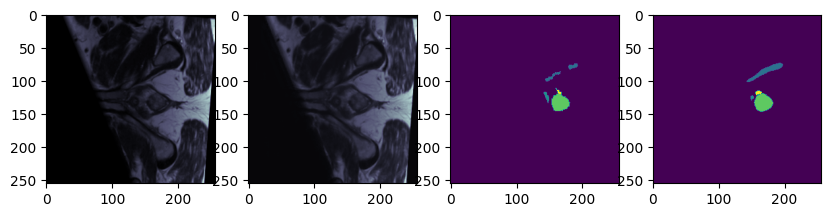

In [53]:
# Visualize input and reconstructed image
indx = 10
fig, ax = plt.subplots(1, 4, figsize = (10, 10))
ax[0].imshow(inputs[0, 0, indx, :, :].cpu().numpy(), cmap = 'bone')
ax[1].imshow(recon_output[0, 0, :, :, indx].cpu().detach().numpy(), cmap = 'bone')
ax[2].imshow(labels[0, 0, :, :, indx].cpu().numpy())
ax[3].imshow(torch.argmax(output, dim = 1)[0, :, :, indx].detach().cpu().numpy())
plt.show()


In [50]:
torch.argmax(output, dim = 1).shape

torch.Size([2, 256, 256, 40])

In [15]:
print(
                f"\nCurrent epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nBest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
                f"\nCurrent epoch: {epoch + 1} current mean ssim: {recon_metric:.4f}"
                )

print(f"Done training! Best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")


Current epoch: 100 current mean dice: 0.8168
Best mean dice: 0.8170 at epoch: 90
Current epoch: 100 current mean ssim: 0.9530
Done training! Best mean dice: 0.8170 at epoch: 90


In [16]:
# Save epoch loss and metric values
import pickle
with open(MODEL_PATH/"mtl_epoch_loss_values.pkl", "wb") as f:
    pickle.dump(epoch_loss_values, f)
with open(MODEL_PATH/"mtl_metric_values.pkl", "wb") as f:
    pickle.dump(metric_values, f)

# # Open the saved files
# with open(MODEL_PATH/"epoch_loss_values.pkl", "rb") as f:
#     epoch_loss_values = pickle.load(f)
# with open(MODEL_PATH/"metric_values.pkl", "rb") as f:
#     metric_values = pickle.load(f)

In [10]:
MODEL_PATH

WindowsPath('models')

In [50]:
sorted(train_image_dir.glob("*"))[96], sorted(train_mask_dir.glob("*"))[96]

(WindowsPath('data/data/train_images/003061_img.nii'),
 WindowsPath('data/data/train_masks/003061_mask.nii'))

In [45]:
train_images[100].name, train_masks[100].name

('003066_img.nii', '003066_mask.nii')

In [62]:
train_dataset[100][0].shape

torch.Size([1, 43, 180, 180])

In [64]:
len(train_dataset)

412

In [67]:
train_dataset[1][0].shape

torch.Size([1, 36, 180, 180])

In [82]:
# For each train file, find size
validation_dataset[10][0].shape
    

torch.Size([1, 46, 199, 199])

In [26]:
model

ResidualAttention3DUnet(
  (down_conv): ModuleList(
    (0): residual_block(
      (first_conv): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (first_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (act1): SiLU()
      (second_conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (second_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (act2): SiLU()
      (dropout): Dropout3d(p=0.2, inplace=False)
      (shortcut): Conv3d(1, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (1): residual_block(
      (first_conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (first_norm): GroupNorm(8, 128, eps=1e-05, affine=True)
      (act1): SiLU()
      (second_conv): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (second_norm): GroupNorm(8, 128, eps=1e-05, affine=True)
      (act2): S

In [27]:
model2 = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=9,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
model2

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [71]:
root_dir = Path("data")

In [72]:
from monai.apps import download_and_extract
# define the link of the dataset
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
# define the hash value to validate the downloaded file
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
# define the path for downloading the .tar file
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
# define the directory for extracting the contents of the .tar file
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    # download, extract and validate the file
    download_and_extract(resource, compressed_file, root_dir, md5)

d:\Eric\multi_task_learning\ml_cw2\multi_task_learning\.venv\lib\site-packages\monai\apps\utils.py:110: UserWarning: tqdm is not installed, will not show the downloading progress bar.
  warnings.warn("tqdm is not installed, will not show the downloading progress bar.")


2023-04-06 18:12:16,422 - INFO - Downloaded: data\Task09_Spleen.tar
2023-04-06 18:12:20,941 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-04-06 18:12:20,941 - INFO - Writing into directory: data.


In [85]:
import glob
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [87]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=4)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

(512, 512, 104) (512, 512, 104)


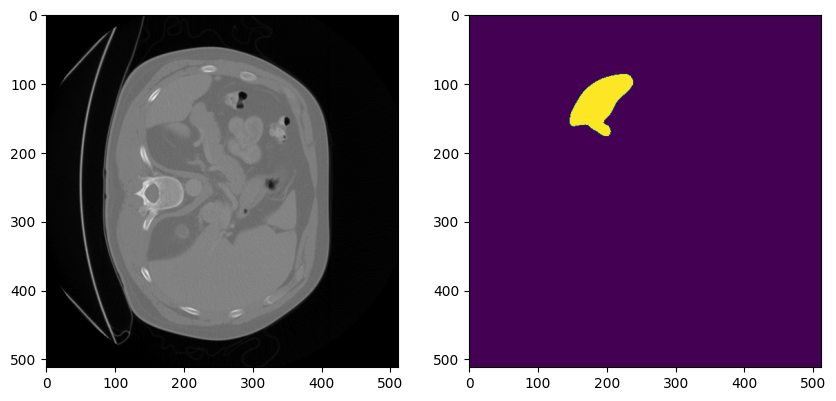

In [108]:
# Spleen training images
import glob
sp_train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# Spleen training labels
sp_train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
#Read the first image and label
img = nib.load(sp_train_images[20]).get_fdata()
label = nib.load(sp_train_labels[20]).get_fdata()
print(img.shape, label.shape)
index = 80
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(img[:, :, index], cmap = "gray")
ax[1].imshow(label[:, :, index])
plt.show()

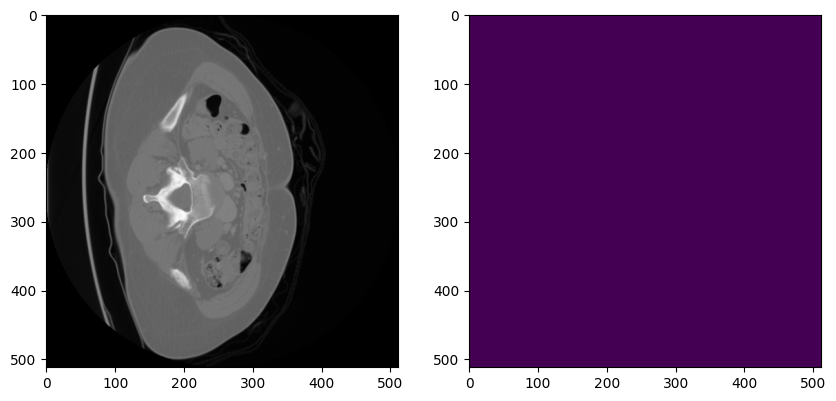

In [102]:
# Plot all the slices
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for i in range(0, 3):
    ax[0].imshow(img[:, :, i], cmap = "gray")
    ax[1].imshow(label[:, :, i])

In [75]:
os.path.join(data_dir, "imagesTr")

'data\\Task09_Spleen\\imagesTr'

### Multi-task learning 2:
In this project, segmentation of a particular set of 
regions of interest (ROIs) in T2-weighted MR images of pelvic is useful for imaging-based surgical 
planning for prostate cancer intervention. This main task may be assisted by **segmenting a number of other surrounding structures** or classification tasks to discriminating whether certain ROIs are present.

```
      ---------------
     |               |
----|   Input Image |
     |               |
      ---------------
             |
         3D U-Net Encoder
             |
    ------------------------
   |        |       |      | 
---| Decoder1 | Decoder2 | Decoder3 | Decoder4 |
   |        |       |      |
    ------------------------
             |
    --------------------------------
   |      |      |     |    |
---|  ROI1  |  ROI2  |  ROI3  | ROI4  |
   |      |      |     |    |
    --------------------------------

```


In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
import os

# Set the random seed for reproducibility
random.seed(2056)

# Read all files ending with _img.nii
img_path = Path("data/data")
img_files = list(img_path.glob("*_img.nii")) # Image and mask are in the same folder
num_images = len(img_files) 

# Create train, validation and test splits
train_split = int(0.7 * num_images)
val_split = int(0.15 * num_images)
test_split = int(num_images - (train_split + val_split))

# Shuffle the image files
random.shuffle(img_files)

# Split the dataset
train_images = img_files[:train_split]
val_images = img_files[train_split:(train_split + val_split)]
test_images = img_files[(train_split + val_split): ]

# Create train, validation and test directories
train_image_dir = Path(img_path / "train_images")
train_mask_dir = Path(img_path / "train_masks")
val_image_dir = Path(img_path / "val_images")
val_mask_dir = Path(img_path / "val_masks")
test_image_dir = Path(img_path / "test_images")
test_mask_dir = Path(img_path / "test_masks")

# Create the directories if they don't exist
if not os.path.exists(train_image_dir) and not os.path.exists(train_mask_dir) and not os.path.exists(val_image_dir) and not os.path.exists(val_mask_dir) and not os.path.exists(test_image_dir) and not os.path.exists(test_mask_dir):
    for directory in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir]:
        directory.mkdir(exist_ok = True, parents = True)

    # Copy the images and their corresponding segmentation masks to their respective directories
    for directory, images in zip([train_image_dir, val_image_dir, test_image_dir], [train_images, val_images, test_images]):
        for image in images:
            # Copy image
            copyfile(image, directory / image.name)

            # Get corresponding segmentation mask
            mask = image.name.replace("_img.nii", "_mask.nii")

            # Copy segmentation mask
            copyfile(image.parent / mask, image.parent / directory.name.replace("images", "masks") / mask)


# # Sanity check
# train_images_s = list(train_image_dir.glob("*"))
# train_images_s = [image.name.removesuffix("_img.nii") for image in train_images_s]
# train_masks_s = list(train_mask_dir.glob("*"))
# train_masks_s = [mask.name.removesuffix("_mask.nii") for mask in train_masks_s]
# train_images_s == train_masks_s








In [2]:
import torch
import torch.nn as nn
import torchvision


# Define a Residual block
class residual_block(nn.Module):
    """
    This class implements a residual block which consists of two convolution layers with group normalization
    """
    def __init__(self, in_channels, out_channels, n_groups = 8):
        super().__init__()
        # First convolution layer
        self.first_conv = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias=False)
        self.first_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act1 = nn.SiLU() # Swish activation function

        # Second convolution layer
        self.second_conv = nn.Conv3d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias = False)
        self.second_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act2 = nn.SiLU() # Swish activation function

        # Add dropout to the residual block
        self.dropout = nn.Dropout3d(p = 0.2)

        # If the number of input channels is not equal to the number of output channels,
        # then use a 1X1 convolution layer to compensate for the difference in dimensions
        # This allows the input to have the same dimensions as the output of the residual block
        if in_channels != out_channels:
            self.shortcut = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)
        else:
            # Pass the input as is
            self.shortcut = nn.Identity()

    # Pass the input through the residual block
    def forward(self, x):
        # Store the input
        input = x

        # Pass input through the first convolution layer
        x = self.act1(self.first_norm(self.first_conv(x)))

        # Pass the output of the first convolution layer through the second convolution layer
        x = self.act2(self.second_norm(self.second_conv(x)))

        # Add dropout
        x = self.dropout(x)


        # Add the input to the output of the second convolution layer
        # This is the skip connection
        x = x + self.shortcut(input)
        return x

# Implement the DownSample block that occurs after each residual block
class down_sample(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool3d(kernel_size = 2, stride = 2)

    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x

# Implement the UpSample block that occurs in the decoder path/expanding path
class up_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer to upsample the input
        self.up_sample = nn.ConvTranspose3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2, bias = False)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x

# Implement the crop and concatenate layer
class crop_and_concatenate(nn.Module):
    def forward(self, upsampled, bypass):
        # Crop the upsampled feature map to match the dimensions of the bypass feature map
        if upsampled.shape[2:] != bypass.shape[2:]:
            upsampled = nn.Upsample(size = bypass.shape[2:], mode="trilinear", align_corners=True)(upsampled)

        #upsampled = torchvision.transforms.functional.resize(upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# Implement an attention block
class attention_block(nn.Module):
    def __init__(self, skip_channels, gate_channels, inter_channels = None, n_groups = 8):
        super().__init__()

        if inter_channels is None:
            inter_channels = skip_channels // 2

        # Implement W_g i.e the convolution layer that operates on the gate signal
        # Upsample gate signal to be the same size as the skip connection
        self.W_g = up_sample(in_channels = gate_channels, out_channels = skip_channels)
        self.W_g_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)
        self.W_g_act = nn.SiLU() # Swish activation function

        # Implement W_x i.e the convolution layer that operates on the skip connection
        self.W_x = nn.Conv3d(in_channels = skip_channels, out_channels = inter_channels, kernel_size = 1, padding = 0, bias = False)
        self.W_x_norm = nn.GroupNorm(num_groups = n_groups, num_channels = inter_channels)
        self.W_x_act = nn.SiLU() # Swish activation function

        # Implement phi i.e the convolution layer that operates on the output of W_x + W_g
        self.phi = nn.Conv3d(in_channels = inter_channels, out_channels = 1, kernel_size = 1, padding = 0, bias = False)
        #self.phi_norm = nn.GroupNorm(num_groups = n_groups, num_channels = 1)
        #self.phi_act = nn.SiLU() # Swish activation function

        # Implement the sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        # Implement the Swish activation function
        self.act = nn.SiLU()

        # Implement final group normalization layer
        self.final_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)

    # Pass the input through the attention block
    def forward(self, skip_connection, gate_signal):
        # Upsample the gate signal to match the channels of the skip connection
        gate_signal = self.W_g(gate_signal)
        # Ensure that the sizes of the skip connection and the gate signal match before addition
        if gate_signal.shape[2:] != skip_connection.shape[2:]:
            gate_signal = nn.Upsample(size = skip_connection.shape[2:], mode="trilinear", align_corners=True)(gate_signal)
            #gate_signal = torchvision.transforms.functional.resize(gate_signal, size = skip_connection.shape[2:], antialias=True)
        # Project to the intermediate channels
        gate_signal = self.W_x(gate_signal)

        # Project the skip connection to the intermediate channels
        skip_signal = self.W_x(skip_connection)

        # Add the skip connection and the gate signal
        add_xg = gate_signal + skip_signal

        # Pass the output of the addition through the activation function
        add_xg = self.act(add_xg)

        # Pass the output of attention through a 1x1 convolution layer to obtain the attention map
        attention_map = self.sigmoid(self.phi(add_xg))

        # Multiply the skip connection with the attention map
        # Perform element-wise multiplication
        skip_connection = torch.mul(skip_connection, attention_map)

        skip_connection = nn.Conv3d(in_channels = skip_connection.shape[1], out_channels = skip_connection.shape[1], kernel_size = 1, bias=False).to(device)(skip_connection)
        skip_connection = self.act(self.final_norm(skip_connection))

        return skip_connection


## Implement a 3D residual attention U-Net
class ResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [16, 32, 64, 128, 256]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])


        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])


        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv3d(in_channels = n_channels[0] , out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []
        # # Store the gate signals
        # gate_signals = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            #gate_signals.append(x)
            x = down_sample(x)
        
        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        skip_connections.append(x)

        # Attention on the residual connections
        n = len(skip_connections)
        indices = [(n - 1 - i, n - 2 - i) for i in range(n - 1)]
        attentions = []
        for i, g_x in enumerate(indices):
            g_gate = g_x[0]
            x_residual = g_x[1]
            attn = self.attention_blocks[i](skip_connections[x_residual], skip_connections[g_gate])
            attentions.append(attn)

        #attentions = attentions[::-1]
    
        # Pass the output of the attention blocks through the expanding path
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, attentions.pop(0))
            x = up_conv(x)

        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x

In [3]:
## Implement a MTL 3D residual attention U-Net
class MTLResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [16, 32, 64, 128, 256]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(len(n_channels) - 1))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])

        ## ------ Decoder block for segmenting main prostate zones: central, transition, background ------ ##
        # Define the attention blocks
        self.attention_blocks_main = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        

        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples_main = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat_main = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv_main = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                            [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv_main = nn.Conv3d(in_channels = n_channels[0], out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)



        ## ------ Decoder block for segmenting the auxilliary zones: Bladder, Rectum, Seminal vesicle, Neurovascular bundle ------ ##
        # Define the attention blocks
        self.attention_blocks_aux = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
       # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples_aux = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat_aux = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv_aux = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                            [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv_aux = nn.Conv3d(in_channels = n_channels[0], out_channels = 4, kernel_size = 1, padding = 0, bias = False) # 3 classes + background

        
        
    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)

        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        

        # Define segmentation and reconstruction variables
        x_main = x
        x_aux = x

        # --- Pass the output of the encoder through the decoder of the main prostate zones --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)
        for up_sample, concat, up_conv in zip(self.upsamples_main, self.concat_main, self.up_conv_main):
            gated_attn = self.attention_blocks_main[attn_block_count](skip_connections[skip_connections_count - 1], x_main)
            attn_block_count += 1
            skip_connections_count -= 1
            x_main = up_sample(x_main)
            x_main = concat(x_main, gated_attn)
            x_main = up_conv(x_main)

        # Pass the output of the main decoder through the final convolution layer
        x_main = self.final_conv_main(x_main) # Output segmentation map for the main prostate zones

    

        # --- Pass the output of the encoder through the decoder of the auxilliary prostate zones --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)
        for up_sample, concat, up_conv in zip(self.upsamples_aux, self.concat_aux, self.up_conv_aux):
            gated_attn = self.attention_blocks_aux[attn_block_count](skip_connections[skip_connections_count - 1], x_aux)
            attn_block_count += 1
            skip_connections_count -= 1
            x_aux = up_sample(x_aux)
            x_aux = concat(x_aux, gated_attn)
            x_aux = up_conv(x_aux)

        # Pass the output of the auxilliary decoder through the final convolution layer
        x_aux = self.final_conv_aux(x_aux) # Output segmentation map for the auxilliary prostate zones

        # Return the segmentations for the main and auxilliary prostate zones
        return x_main, x_aux
    
# Test whether the MTL model works
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelt = MTLResidualAttention3DUnet(in_channels = 1, out_channels = 3).to(device)
x = torch.randn(2, 1, 40, 256, 256).to(device)
x_main, x_aux = modelt(x)
x_main.shape, x_aux.shape




(torch.Size([2, 3, 40, 256, 256]), torch.Size([2, 4, 40, 256, 256]))

In [4]:
#!pip install monai
from monai.utils import first, set_determinism 
from monai.transforms import (
    EnsureChannelFirstd, # Adjust or add the channel dimension of input data to ensure channel_first shape.
    #AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    ScaleIntensityd,
    Spacingd,
    SpatialPadd,
    ToTensord,
    RandAffined, Resized, RandSpatialCropd,
)

# Set deterministic training for reproducibility
set_determinism(seed = 2056)

# Put the train images and masks in a dictionary
train_images = sorted(train_image_dir.glob("*"))
train_masks = sorted(train_mask_dir.glob("*"))
train_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(train_images, train_masks)]

# Put the validation images and masks in a dictionary
val_images = sorted(val_image_dir.glob("*"))
val_masks = sorted(val_mask_dir.glob("*"))
val_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(val_images, val_masks)]

# Put the test images and masks in a dictionary
test_images = sorted(test_image_dir.glob("*"))
test_masks = sorted(test_mask_dir.glob("*"))
test_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(test_images, test_masks)]

# Create transforms for training
train_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"), # Interpolation mode for image and mask
        ),
        RandAffined(
            keys = ["image", "mask"],
            mode = ("bilinear", "nearest"),
            prob = 1.0,
            spatial_size = (256, 256, 40), # Output size of the image [height, width, depth]
            #rotate_range = (np.pi / 36, np.pi / 36, np.pi / 36), # Rotation range
            scale_range = (0.1, 0.1, 0.1), # Scaling range
            padding_mode="zeros", # This means that the image will be padded with zeros
        )

        
    ]
)

# Create transforms for validation
val_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"),
        ),
        # since we are not doing data augmentation during validation,
        #we simply center crop the image and mask to the specified size of [256, 256, 40]
        CenterSpatialCropd(keys = ["image", "mask"], roi_size = (256, 256, 40)), 
        SpatialPadd(keys = ["image", "mask"], spatial_size= (256, 256, 40)) # Some images are smaller than 256x256x40, so we pad them to this size


        

    ]
)

### Create training loop

In [5]:
organs = ["Background", "Bladder", "Bone", "Obturator internus", "Transition zone", "Central gland",
          "Rectum", "Seminal vesicle", "Neurovascular bundle"]
# Create an index dictionary
organs_dict = {organ: idx for idx, organ in enumerate(organs)}
organs_dict

{'Background': 0,
 'Bladder': 1,
 'Bone': 2,
 'Obturator internus': 3,
 'Transition zone': 4,
 'Central gland': 5,
 'Rectum': 6,
 'Seminal vesicle': 7,
 'Neurovascular bundle': 8}

In [6]:
torch.cuda.empty_cache()
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
#from tqdm import tqdm
BATCH_SIZE = 2
#train_ds = CacheDataset(data = train_files, transform = train_transforms, cache_rate = 1.0, num_workers = 4)
train_ds = Dataset(data = train_files, transform = train_transforms)
train_dl = DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

#val_ds = CacheDataset(data = val_files, transform = val_transforms, cache_rate = 1.0, num_workers = 4)
val_ds = Dataset(data = val_files, transform = val_transforms)
val_dl = DataLoader(dataset = val_ds, batch_size = BATCH_SIZE, num_workers = 4, shuffle = False)

In [7]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Input image has eight anatomical structures of planning interest
model = MTLResidualAttention3DUnet(in_channels = 1, out_channels = 3).to(device)# 2 structures + background
loss_function = DiceLoss(to_onehot_y = True, softmax = True, include_background=False) # For segmentation Expects BNHW[D] input i.e. batch, channel, height, width, depth, performs softmax on the channel dimension to get a probability distribution
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric_main = DiceMetric(include_background=False, reduction="mean")# Collect the loss and metric values for every iteration
dice_metric_aux = DiceMetric(include_background=False, reduction="mean")
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 100, eta_min = 1e-6) # Adopt a cosine annealing learning rate schedule which reduces the learning rate as the training progresses


In [8]:
# Import AsDiscrete transform to convert the output to discrete values
from skimage.metrics import structural_similarity as ssim
from monai.transforms import AsDiscrete
from pathlib import Path
# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "CW_MTL_pytorch_male_pelvic_segmentation_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_aux_loss_values = []
epoch_total_loss_values = []
main_metric_values = []
aux_metric_values = []

# Post transforms for the main prostate zones: 2 classes + background
post_pred_transform_main = Compose([AsDiscrete(argmax = True, to_onehot = 3)])
post_label_transform_main = Compose([AsDiscrete(to_onehot = 3)])

# Post transforms for the auxilliary prostate zones: 3 classes + background
post_pred_transform_aux = Compose([AsDiscrete(argmax = True, to_onehot = 4)])
post_label_transform_aux = Compose([AsDiscrete(to_onehot = 4)])

# Loss weights
main_weight = 1.5
aux_weight = 1.0

#CUDA_LAUNCH_BLOCKING=1


for epoch in range(max_epochs):
    print("-" * 20)
    print(f"Epoch {epoch + 1} / {max_epochs}")
    # Put the model into training mode
    model.train()
    epoch_loss = 0
    epoch_aux_loss = 0
    epoch_total_loss = 0
    step = 0
    for batch in train_dl:
        step = step + 1
        inputs = batch["image"].permute(0, 1, 4, 2, 3).to(device)
        labels = batch["mask"].to(device) # Permute beccause of torch upsample

        # Modify the main labels to match the output of the main decoder
        main_labels = labels.clone()
        main_labels[(main_labels != organs_dict['Transition zone']) & (main_labels != organs_dict['Central gland'])] = 0
        main_labels[main_labels == organs_dict['Transition zone']] = 1
        main_labels[main_labels == organs_dict['Central gland']] = 2

        # Modify the auxilliary labels to match the output of the auxilliary decoder
        aux_labels = labels.clone()
        aux_labels[(aux_labels != organs_dict['Bladder']) & (aux_labels != organs_dict['Rectum']) & (aux_labels != organs_dict['Seminal vesicle'])] = 0
        aux_labels[aux_labels == organs_dict['Bladder']] = 1
        aux_labels[aux_labels == organs_dict['Rectum']] = 2
        aux_labels[aux_labels == organs_dict['Seminal vesicle']] = 3
        
        


        # Forward pass
        main_seg, aux_seg = model(inputs) 
        main_seg, aux_seg = main_seg.permute(0, 1, 3, 4, 2), aux_seg.permute(0, 1, 3, 4, 2) # Permute back to BNHWD

        # Compute the loss functions
        main_seg_loss = loss_function(main_seg, main_labels)
        aux_seg_loss = loss_function(aux_seg, aux_labels)

        # Compute the total loss
        loss = main_weight * main_seg_loss + aux_weight * aux_seg_loss

        # Zero the gradients
        optimizer.zero_grad()

        # Find the gradients of the loss w.r.t the model parameters
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Add the loss to the epoch loss
        epoch_loss = epoch_loss + main_seg_loss.item()
        epoch_aux_loss = epoch_aux_loss + aux_seg_loss.item()
        epoch_total_loss = epoch_total_loss + loss.item()
    # Compute the average loss of the epoch
    epoch_loss = epoch_loss / step
    epoch_aux_loss = epoch_aux_loss / step
    epoch_total_loss = epoch_total_loss / step
    epoch_loss_values.append(epoch_loss)
    epoch_total_loss_values.append(epoch_total_loss)
    epoch_aux_loss_values.append(epoch_aux_loss)


    # Print the average loss of the epoch
    print(f"\nEpoch {epoch + 1} average dice loss for main task: {epoch_loss:.4f}")
    print(f"\nEpoch {epoch + 1} average dice loss for aux task: {epoch_aux_loss:.4f}")
    print(f"\nEpoch {epoch + 1} average total loss for both tasks: {epoch_total_loss:.4f}")

    # Step the scheduler after every epoch
    scheduler.step()

    # Print loss and evaluate model when epoch is divisible by val_interval
    if (epoch + 1) % val_interval == 0:
        #print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        # Put the model into evaluation mode
        model.eval()
        # Disable gradient calculation
        with torch.inference_mode():
            # Loop through the validation data
            for val_data in val_dl:
                val_inputs, val_labels = val_data["image"].permute(0, 1, 4, 2, 3).to(device), val_data["mask"].to(device)
                # Modify the main labels to match the output of the main decoder
                val_main_labels = val_labels.clone()
                val_main_labels[(val_main_labels != organs_dict['Transition zone']) & (val_main_labels != organs_dict['Central gland'])] = 0
                val_main_labels[val_main_labels == organs_dict['Transition zone']] = 1
                val_main_labels[val_main_labels == organs_dict['Central gland']] = 2

                # Modify the auxilliary labels to match the output of the auxilliary decoder
                val_aux_labels = val_labels.clone()
                val_aux_labels[(val_aux_labels != organs_dict['Bladder']) & (val_aux_labels != organs_dict['Rectum']) & (val_aux_labels != organs_dict['Seminal vesicle'])] = 0
                val_aux_labels[val_aux_labels == organs_dict['Bladder']] = 1
                val_aux_labels[val_aux_labels == organs_dict['Rectum']] = 2
                val_aux_labels[val_aux_labels == organs_dict['Seminal vesicle']] = 3

                # Forward pass
                val_main_outputs, val_aux_outputs = model(val_inputs)
                val_main_outputs, val_aux_outputs = val_main_outputs.permute(0, 1, 3, 4, 2), val_aux_outputs.permute(0, 1, 3, 4, 2)

                # Transform main outputs and labels to calculate inference loss
                val_main_outputs = [post_pred_transform_main(i) for i in decollate_batch(val_main_outputs)]
                val_main_labels = [post_label_transform_main(i) for i in decollate_batch(val_main_labels)]

                # Transform aux outputs and labels to calculate inference loss
                val_aux_outputs = [post_pred_transform_aux(i) for i in decollate_batch(val_aux_outputs)]
                val_aux_labels = [post_label_transform_aux(i) for i in decollate_batch(val_aux_labels)]


                # Compute dice metric for current iteration
                dice_metric_main(y_pred = val_main_outputs, y = val_main_labels)
                dice_metric_aux(y_pred = val_aux_outputs, y = val_aux_labels)

            # Compute the average metric value across all iterations
            main_metric = dice_metric_main.aggregate().item()
            aux_metric = dice_metric_aux.aggregate().item()
            main_metric_values.append(main_metric)
            aux_metric_values.append(aux_metric)
            
            # Reset the metric for next validation run
            dice_metric_main.reset()
            dice_metric_aux.reset()


            # If the metric is better than the best seen so far, save the model
            if main_metric > best_metric:
                best_metric = main_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print("saved new best metric model")
            
            print(
                f"\nCurrent epoch: {epoch + 1} current mean dice for main task: {main_metric:.4f}"
                f"\nBest mean dice for main task: {best_metric:.4f} at epoch: {best_metric_epoch}"
                f"\nCurrent epoch: {epoch + 1} current mean dice for aux task: {aux_metric:.4f}"
                )
            

# When training is complete:
print(f"Done training! Best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

                


--------------------
Epoch 1 / 100


d:\Eric\multi_task_learning\ml_cw2\multi_task_learning\.venv\lib\site-packages\monai\data\__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)



Epoch 1 average dice loss for main task: 0.7724

Epoch 1 average dice loss for aux task: 0.7511

Epoch 1 average total loss for both tasks: 1.9097
--------------------
Epoch 2 / 100

Epoch 2 average dice loss for main task: 0.4703

Epoch 2 average dice loss for aux task: 0.5671

Epoch 2 average total loss for both tasks: 1.2725
--------------------
Epoch 3 / 100

Epoch 3 average dice loss for main task: 0.4173

Epoch 3 average dice loss for aux task: 0.5364

Epoch 3 average total loss for both tasks: 1.1624
--------------------
Epoch 4 / 100

Epoch 4 average dice loss for main task: 0.3836

Epoch 4 average dice loss for aux task: 0.5196

Epoch 4 average total loss for both tasks: 1.0950
--------------------
Epoch 5 / 100

Epoch 5 average dice loss for main task: 0.3522

Epoch 5 average dice loss for aux task: 0.5054

Epoch 5 average total loss for both tasks: 1.0337
--------------------
Epoch 6 / 100

Epoch 6 average dice loss for main task: 0.3256

Epoch 6 average dice loss for aux t

In [14]:
inputs.shape, main_labels.shape, aux_labels.shape, main_seg.shape, aux_seg.shape

(torch.Size([2, 1, 40, 256, 256]),
 torch.Size([2, 1, 256, 256, 40]),
 torch.Size([2, 1, 256, 256, 40]),
 torch.Size([2, 9, 256, 256, 40]),
 torch.Size([2, 9, 256, 256, 40]))

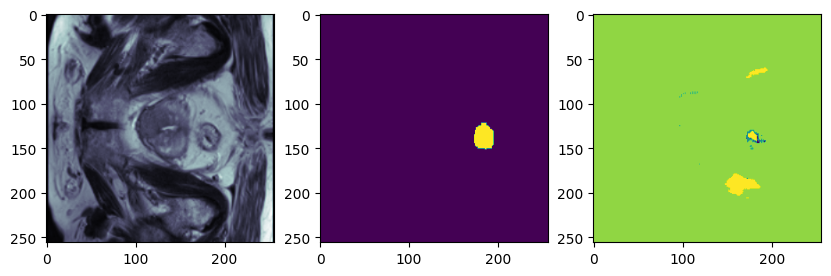

In [24]:
# Visualize input and reconstructed image
indx = 20
fig, ax = plt.subplots(1, 3, figsize = (10, 10))
ax[0].imshow(inputs[0, 0, indx, :, :].cpu().numpy(), cmap = 'bone')
ax[1].imshow(aux_labels[0, 0, :, :, indx].cpu().detach().numpy())
#ax[2].imshow(labels[0, 0, :, :, indx].cpu().numpy())
ax[2].imshow(torch.argmax(aux_seg, dim = 1)[0, :, :, indx].detach().cpu().numpy())
plt.show()

In [26]:
aux_labels.unique(), torch.argmax(aux_seg, dim = 1).unique(), torch.argmax(aux_seg, dim = 1)[0, :, :, indx].unique()

(tensor([0., 1., 6., 7.], device='cuda:0'),
 tensor([0, 1, 3, 4, 5, 6, 7, 8], device='cuda:0'),
 tensor([0, 3, 4, 5, 6], device='cuda:0'))

In [22]:
main_labels.unique(), torch.argmax(main_seg, dim = 1).unique()

(tensor([0., 4., 5.], device='cuda:0'), tensor([0, 5], device='cuda:0'))

In [ ]:
# Change main labels  to be 0, 1, 2
main_labels[(main_labels != organs_dict['Transition zone']) & (main_labels != organs_dict['Central gland'])] = 0
main_labels[main_labels == organs_dict['Transition zone']] = 1
main_labels[main_labels == organs_dict['Central gland']] = 2


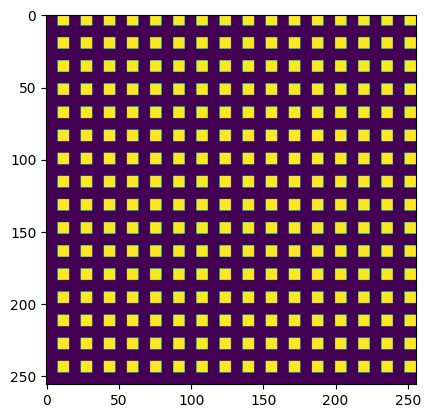

In [20]:
plt.imshow(torch.argmax(main_seg, dim = 1)[1, :, :, indx].detach().cpu().numpy())

In [29]:
batch["image"].permute(0, 1, 4, 2, 3).shape, batch["mask"].shape

(torch.Size([2, 1, 40, 256, 256]), torch.Size([2, 1, 256, 256, 40]))

In [55]:
labels.unique()
# If labels are not 1, or 2, then change to 0
labels[labels != 1] = 0
labels[labels == 2] = 1


tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.], device='cuda:0')

In [46]:
model

MTLResidualAttention3DUnet(
  (down_conv): ModuleList(
    (0): residual_block(
      (first_conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (first_norm): GroupNorm(8, 16, eps=1e-05, affine=True)
      (act1): SiLU()
      (second_conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (second_norm): GroupNorm(8, 16, eps=1e-05, affine=True)
      (act2): SiLU()
      (dropout): Dropout3d(p=0.2, inplace=False)
      (shortcut): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (1): residual_block(
      (first_conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (first_norm): GroupNorm(8, 32, eps=1e-05, affine=True)
      (act1): SiLU()
      (second_conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (second_norm): GroupNorm(8, 32, eps=1e-05, affine=True)
      (act2): SiL